In [79]:
# !pip install nb_black --user
# !pip install xgboost --user
# !pip install lightgbm --user
# !pip install neptune-client --user
# !pip install catboost --user
# !pip install neptune-contrib
# !pip install plotly -- user
# !pip install --upgrade tables --user
# !pip install optuna --user

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [83]:
!jupyter labextension install jupyterlab-plotly@4.11.0

Building jupyterlab assets (build:prod:minimize)


In [1]:
import optuna
import pandas as pd
import numpy as np

# import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    cross_val_score,
    cross_val_predict,
)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

# from plotly import tools
import neptune
from neptunecontrib.api import log_chart

import scoring

from tqdm.notebook import tqdm
from tqdm.auto import tqdm as tqdm_auto

tqdm_auto.pandas()
from copy import deepcopy
import os
import re
import pickle
from itertools import chain
from collections import Counter

import time

%matplotlib inline
sns.set()
%load_ext lab_black

### NEPTUNE logger 

In [2]:
os.environ[
    "NEPTUNE_API_TOKEN"
] = #token

In [3]:
neptune.init(project_qualified_name="nrjjj/muon")

Project(nrjjj/muon)

In [ ]:
experiment = neptune.create_experiment(
    name="moar_features",
    upload_source_files=["sandbox.ipynb"],
)

### Чтение датки 

In [5]:
DATA_PATH = "/data/mnostrouhov/pds/muon/"
GLOBAL_SEED = 333

In [6]:
def load_data_csv(path):
    train = pd.concat(
        [pd.read_hdf(os.path.join(path, f"train_part_{i}_v2.hdf")) for i in (1, 2)],
        axis=0,
        ignore_index=True,
    )
    test = pd.read_hdf(os.path.join(path, "test_public_v2.hdf"))
    private_test = pd.read_hdf(os.path.join(path, "test_private_v2_track_1.hdf"))
    return train, test, private_test

In [7]:
df_train, df_test, df_private_test = load_data_csv(DATA_PATH)
print(f"Train size:{df_train.shape}")
print(f"Test size:{df_test.shape}")

Train size:(5445705, 79)
Test size:(726095, 74)


In [8]:
df_train = df_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
df_test = df_test.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
df_private_test = df_private_test.rename(
    columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x)
)

In [11]:
display(df_train.head())
display(df_test.head())

,ncl0,ncl1,ncl2,ncl3,avg_cs0,avg_cs1,avg_cs2,avg_cs3,ndof,MatchedHit_TYPE0,...,FOI_hits_T,FOI_hits_DT,FOI_hits_S,PT,P,sWeight,particle_type,label,kinWeight,weight
0,47,31,13,15,2.000000,1.580645,1.153846,1.133333,8,2,...,"[3, 11, 2, 7, 7, 5]","[0, 8, 0, 0, 0, 0]","[0, 0, 1, 2, 2, 3]",1764.925899,12646.817591,1.199231,1,1,1.85646,2.226325
1,92,19,11,26,2.750000,2.789474,1.363636,1.230769,8,2,...,"[9, 10, 8, 4]","[1, -1, 0, 4]","[0, 1, 2, 3]",4511.281266,28556.630027,1.145788,1,1,1.85646,2.127109
2,100,21,11,12,2.930000,2.428571,1.181818,1.083333,8,2,...,"[10, 4, 13, 13, 3, 3, 15, 3, 5]","[0, 4, 10, 6, 0, -4, 15, 0, 0]","[0, 0, 1, 1, 1, 1, 1, 2, 3]",1062.550086,17491.702634,1.139144,1,1,3.77936,4.305235
3,74,27,13,20,3.067568,2.518518,1.923077,1.300000,8,2,...,"[6, 6, 4, 8, 2]","[1, -6, 0, 0, 0]","[0, 0, 1, 2, 3]",4991.074825,37192.868559,0.864863,1,1,1.85646,1.605583
4,18,22,8,8,1.833333,1.954545,1.125000,1.750000,8,2,...,"[5, 10, 6, 6, 5, 5]","[0, 5, -2, 0, 0, 0]","[0, 0, 0, 1, 2, 3]",1347.704888,16688.746174,1.107431,1,1,1.85646,2.055900


,ncl0,ncl1,ncl2,ncl3,avg_cs0,avg_cs1,avg_cs2,avg_cs3,ndof,MatchedHit_TYPE0,...,FOI_hits_Y,FOI_hits_Z,FOI_hits_DX,FOI_hits_DY,FOI_hits_DZ,FOI_hits_T,FOI_hits_DT,FOI_hits_S,PT,P
0,55,12,10,15,2.127273,1.166667,1.500000,1.600000,8,2,...,"[-1849.3373, -1826.5162, -1833.7968, -1982.797...","[15396.441, 16315.722, 16404.695, 16521.16, 17...","[12.75, 13.75, 13.75, 13.75, 59.0, 63.0]","[63.078957, 68.078926, 68.078926, 68.078926, 7...","[33.727364, 33.74537, 33.74537, 33.74537, 33.7...","[6, 13, 2, 2, 7, 3]","[-1, 0, -2, -1, 0, 0]","[0, 1, 1, 1, 2, 3]",1174.484530,6884.502272
1,43,18,12,15,2.697675,1.111111,1.333333,1.600000,8,2,...,"[-383.5468, -222.24156, -240.82657, -240.82657...","[15401.72, 15117.299, 16321.432, 16321.432, 17...","[6.375, 6.375, 6.875, 82.5, 29.5, 29.5, 31.5]","[126.27855, 31.479162, 33.979145, 33.979145, 3...","[33.95495, 33.613575, 33.622578, 33.622578, 33...","[6, 4, 5, 9, 12, 6, 3]","[6, 0, -2, 9, -1, -1, 0]","[0, 0, 1, 1, 2, 2, 3]",4344.639775,48769.526891
2,90,34,19,29,1.800000,2.058824,1.210526,1.344828,8,2,...,"[-1628.1324, -1758.3168, -1887.1799, -2014.6083]","[15112.236, 16315.968, 17508.303, 18715.945]","[25.5, 27.5, 118.0, 126.0]","[126.27855, 136.27849, 146.27841, 156.27835]","[33.95495, 33.99096, 34.026966, 34.062977]","[3, 10, 7, 7]","[-1, 0, 0, 0]","[0, 1, 2, 3]",4109.805750,20296.048412
3,141,43,15,16,4.609929,2.744186,1.466667,1.125000,8,2,...,"[372.85458, 537.1497, 483.45386, 483.45386, 52...","[15119.441, 15321.034, 15119.84, 15119.84, 163...","[3.2083333, 76.5, 3.2083333, 3.2083333, 3.4583...","[126.27855, 31.479162, 15.679264, 15.679264, 1...","[33.95495, 33.613575, 33.55668, 33.55668, 33.5...","[14, 13, 3, 4, 5, 6, 8, 7, 3]","[14, 13, 1, 2, 1, 0, 2, 7, 0]","[0, 0, 0, 0, 1, 2, 2, 2, 3]",940.242439,26062.046122
4,22,18,8,9,1.636364,2.444444,1.000000,1.555556,8,2,...,"[264.6528, 367.2695, 284.41754, 305.50333, 328...","[15203.053, 16323.622, 16407.324, 17600.2, 188...","[3.2083333, 82.5, 3.4583333, 14.833333, 15.833...","[15.679264, 33.979145, 16.929256, 18.179249, 1...","[33.55668, 33.622578, 33.56118, 33.56568, 33.5...","[8, 5, 7, 5, 2, 13, 5, 6]","[1, 5, 0, 5, 2, 13, 5, 6]","[0, 1, 1, 2, 3, 3, 3, 3]",1386.377851,59872.343332


In [13]:
df_train, df_valid = train_test_split(
    df_train,
    train_size=0.4,
    test_size=0.05,
    random_state=GLOBAL_SEED,
    shuffle=True,
    stratify=df_train["label"],
)

In [14]:
display(df_train.head())
display(df_valid.head())

,ncl0,ncl1,ncl2,ncl3,avg_cs0,avg_cs1,avg_cs2,avg_cs3,ndof,MatchedHit_TYPE0,...,FOI_hits_T,FOI_hits_DT,FOI_hits_S,PT,P,sWeight,particle_type,label,kinWeight,weight
5271239,13,13,6,5,2.076923,2.153846,1.333333,1.400000,8,2,...,"[3, 5, 5, 1, 3, 3, 4, 3, 8]","[-1, 5, -10, -14, 1, 1, 2, 0, 0]","[0, 0, 1, 1, 1, 1, 1, 2, 3]",2209.385880,38006.332407,1.052345,1,1,1.85646,1.953636
452195,71,17,14,8,3.816901,2.352941,1.642857,1.000000,8,2,...,"[6, 8, 9, 6, 6, 7]","[0, 0, 1, 6, 6, 7]","[0, 1, 1, 2, 3, 3]",4957.291019,137046.777545,1.219424,1,1,3.00000,3.658273
5412008,81,10,7,9,2.876543,1.400000,1.000000,1.222222,8,2,...,"[10, 11, 10, 11, 6, 6, 5, 9]","[3, 4, 0, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 1, 2, 2, 3]",1212.343683,6240.248635,1.203003,1,1,1.85646,2.233327
3773018,25,6,3,6,2.080000,1.000000,1.333333,1.000000,8,2,...,"[3, 9, 7, 8]","[0, 1, -1, -1]","[0, 1, 2, 3]",3059.933560,33736.286948,1.209923,1,1,1.85646,2.246173
3207395,22,2,2,5,1.545455,1.500000,1.000000,1.200000,8,2,...,"[4, 3, 3, 7, 5]","[0, -4, 0, 0, 0]","[0, 1, 1, 2, 3]",1539.810222,40739.699970,1.080711,1,1,1.85646,2.006296


,ncl0,ncl1,ncl2,ncl3,avg_cs0,avg_cs1,avg_cs2,avg_cs3,ndof,MatchedHit_TYPE0,...,FOI_hits_T,FOI_hits_DT,FOI_hits_S,PT,P,sWeight,particle_type,label,kinWeight,weight
4517692,35,6,8,11,2.885714,3.666667,1.375000,1.000000,8,2,...,"[7, 7, 2, 6, 11, 6, 1, 5, 8, 4]","[0, 0, 2, 3, 8, 3, -2, 1, -1, 0]","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3]",1091.295038,15777.107432,-0.425461,1,1,1.85646,-0.789851
134032,21,4,3,6,1.476190,1.250000,2.000000,2.500000,8,2,...,"[10, 4, 5, 7, 11, 11, 4, 4, 6, 6, 15, 15]","[10, -2, -7, 1, 7, -1, 0, -8, -1, 5, 8, 14]","[0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3]",8724.773419,155013.606986,-0.115114,1,1,2.80650,-0.323069
2143828,51,12,7,12,2.196079,4.666667,2.428571,1.333333,8,2,...,"[5, 8, 1, 2, 6, 7, 7, 6, 6, 6, 4]","[5, 7, 0, 1, 0, -2, 0, -6, 0, 0, 0]","[0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 3]",2578.549906,45351.833096,-0.418960,1,1,1.85646,-0.777783
2754845,68,7,6,12,2.514706,1.428571,1.166667,1.416667,8,2,...,"[1, 9, 9, 5, 2, 9, 6]","[1, 2, 9, 1, 0, 0, -1]","[0, 0, 0, 1, 2, 2, 3]",1267.846267,7957.915083,1.235896,1,1,1.85646,2.294392
4419965,30,17,23,18,1.766667,2.235294,1.826087,1.055556,8,2,...,"[8, 6, 5, 5, 9, 9, 3, 5]","[0, 0, 0, -4, 4, 0, -1, 0]","[0, 1, 2, 2, 2, 2, 3, 3]",2493.213864,10350.507597,1.144913,1,1,1.85646,2.125485


### Фичи

In [15]:
TARGET_COLS = df_train.columns.difference(df_test.columns)

In [16]:
FOI_COLS = df_train.columns[["FOI" in col for col in df_train.columns]]

In [17]:
BASIC_FEATURES = df_train.columns.difference(
    list(FOI_COLS) + ["id"] + list(TARGET_COLS)
)

In [18]:
def fillna(df_train, df_test=None, df_private_test=None):
    match_coords = {
        0: [
            "MatchedHit_DX0",
            "MatchedHit_DY0",
            "MatchedHit_DZ0",
        ],
        1: [
            "MatchedHit_DX1",
            "MatchedHit_DY1",
            "MatchedHit_DZ1",
        ],
        2: [
            "MatchedHit_DX2",
            "MatchedHit_DY2",
            "MatchedHit_DZ2",
        ],
        3: [
            "MatchedHit_DX3",
            "MatchedHit_DY3",
            "MatchedHit_DZ3",
        ],
    }
    t_cols = [
        "MatchedHit_T0",
        "MatchedHit_T1",
        "MatchedHit_T2",
        "MatchedHit_T3",
    ]
    for df in [df_train, df_test, df_private_test]:
        if df is not None:
            all_d_columns = list(chain.from_iterable(match_coords.values()))
            all_columns = [col.replace("D", "") for col in all_d_columns]
            for cols in [all_d_columns, all_columns]:
                df[cols] = df[cols].replace(-9999, np.nan)
                df[cols] = df[cols].fillna(df[cols].median())

            df[t_cols] = df[t_cols].replace(255, np.nan)
            df[t_cols] = df[t_cols].fillna(df[t_cols].median())

    return df_train, df_test, df_private_test

In [19]:
def ncl_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/ncl_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        ncl_features = ["ncl0", "ncl1", "ncl2", "ncl3"]
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                df["ncl_max"] = df[ncl_features].max(axis=1)
                df["ncl_sum"] = df[ncl_features].sum(axis=1)
                df["ncl_min"] = df[ncl_features].min(axis=1)
                df["ncl_mean"] = df[ncl_features].mean(axis=1)
                df["ncl_std"] = df[ncl_features].std(axis=1)

        new_columns = ["ncl_max", "ncl_sum", "ncl_min", "ncl_mean", "ncl_std"]
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )

    return new_columns, df_train, df_test, df_private_test

In [20]:
def avg_cs(df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""):
    _name = f"{DATA_PATH}features/avg_cs_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        avg_cs_features = ["avg_cs0", "avg_cs1", "avg_cs2", "avg_cs3"]
        ncl_features = ["ncl0", "ncl1", "ncl2", "ncl3"]
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                df["avg_cs_max"] = df[avg_cs_features].max(axis=1)
                df["avg_cs_sum"] = df[avg_cs_features].sum(axis=1)
                df["avg_cs_min"] = df[avg_cs_features].min(axis=1)
                df["avg_cs_mean"] = df[avg_cs_features].mean(axis=1)
                df["avg_cs_std"] = df[avg_cs_features].std(axis=1)
                avg_total_points = df[ncl_features].values * df[avg_cs_features].values
                new_column_names = ["total_cs0", "total_cs1", "total_cs2", "total_cs3"]
                df[new_column_names] = pd.DataFrame(avg_total_points, index=df.index)
                df["total_cs_max"] = df[new_column_names].max(axis=1)
                df["total_cs_sum"] = df[new_column_names].sum(axis=1)
                df["total_cs_min"] = df[new_column_names].min(axis=1)
                df["total_cs_mean"] = df[new_column_names].mean(axis=1)
                df["total_cs_std"] = df[new_column_names].std(axis=1)
        new_columns = (
            new_column_names
            + [
                "total_cs_max",
                "total_cs_sum",
                "total_cs_min",
                "total_cs_mean",
                "total_cs_std",
            ]
            + [
                "avg_cs_max",
                "avg_cs_sum",
                "avg_cs_min",
                "avg_cs_mean",
                "avg_cs_std",
            ]
        )
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [21]:
def matchhit_type_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/matchhit_type_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        match_type_features = [
            "MatchedHit_TYPE0",
            "MatchedHit_TYPE1",
            "MatchedHit_TYPE2",
            "MatchedHit_TYPE3",
        ]
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                for c in range(3):
                    df[f"MatchedHit_count_{c}"] = (
                        df[match_type_features].apply(lambda x: x == c).sum(axis=1)
                    )
                    cumsum_aggs = (
                        df[match_type_features]
                        .apply(lambda x: x == c)
                        .cumsum(axis=1)
                        .values
                    )
                    cumsum_aggs_names = [
                        f"{col}_cumsum_{c}" for col in match_type_features
                    ]
                    df[cumsum_aggs_names] = pd.DataFrame(
                        cumsum_aggs, index=df.index, columns=cumsum_aggs_names
                    )
        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [22]:
def matchhit_coords_features(
    df_train,
    df_test=None,
    df_private_test=None,
    match_coords=None,
    load_saved=False,
    data_tag="",
):
    _name = f"{DATA_PATH}features/matchhit_coords_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        if not match_coords:
            match_coords = {
                0: [
                    "MatchedHit_X0",
                    "MatchedHit_Y0",
                    "MatchedHit_Z0",
                ],
                1: [
                    "MatchedHit_X1",
                    "MatchedHit_Y1",
                    "MatchedHit_Z1",
                ],
                2: [
                    "MatchedHit_X2",
                    "MatchedHit_Y2",
                    "MatchedHit_Z2",
                ],
                3: [
                    "MatchedHit_X3",
                    "MatchedHit_Y3",
                    "MatchedHit_Z3",
                ],
            }
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                for type_ in range(4):
                    df[f"XYZdistance_from_center_type_{type_}"] = np.sqrt(
                        df[match_coords[type_]].apply(lambda x: x ** 2).sum(axis=1)
                    )
                    # to polar
                    df[f"lat_angle_type_{type_}"] = np.arccos(
                        df[f"MatchedHit_Z{type_}"]
                        / df[f"XYZdistance_from_center_type_{type_}"]
                    )
                    df[f"long_angle_type_{type_}"] = np.arctan2(
                        df[f"MatchedHit_Y{type_}"], df[f"MatchedHit_X{type_}"]
                    )

                    df[f"XYdistance_from_center_type_{type_}"] = np.sqrt(
                        df[match_coords[type_][:-1]].apply(lambda x: x ** 2).sum(axis=1)
                    )

                dist_cols = [f"XYZdistance_from_center_type_{i}" for i in range(4)] + [
                    f"XYdistance_from_center_type_{i}" for i in range(4)
                ]
                lat_cols = [f"lat_angle_type_{i}" for i in range(4)]
                long_cols = [f"long_angle_type_{i}" for i in range(4)]
                for polar_cols in [dist_cols, lat_cols, long_cols]:
                    polar_prefix = polar_cols[0].rsplit("_", 2)[0]
                    df[f"{polar_prefix}_max"] = df[polar_cols].max(axis=1)
                    df[f"{polar_prefix}_sum"] = df[polar_cols].sum(axis=1)
                    df[f"{polar_prefix}_min"] = df[polar_cols].min(axis=1)
                    df[f"{polar_prefix}_mean"] = df[polar_cols].mean(axis=1)
                    df[f"{polar_prefix}_std"] = df[polar_cols].std(axis=1)

                for col_coord in ["X", "Y", "Z"]:
                    coord_cols = [f"MatchedHit_{col_coord}{i}" for i in range(4)]
                    df[f"{col_coord}_coord_max"] = df[coord_cols].max(axis=1)
                    df[f"{col_coord}_coord_sum"] = df[coord_cols].sum(axis=1)
                    df[f"{col_coord}_coord_min"] = df[coord_cols].min(axis=1)
                    df[f"{col_coord}_coord_mean"] = df[coord_cols].mean(axis=1)
                    df[f"{col_coord}_coord_std"] = df[coord_cols].std(axis=1)

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [23]:
def matchhit_relative_coords_features(
    df_train,
    df_test=None,
    df_private_test=None,
    match_coords=None,
    load_saved=False,
    data_tag="",
):
    _name = f"{DATA_PATH}features/matchhit_relative_coords_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        if not match_coords:
            match_coords = {
                "X": [
                    "MatchedHit_X0",
                    "MatchedHit_X1",
                    "MatchedHit_X2",
                    "MatchedHit_X3",
                ],
                "Y": [
                    "MatchedHit_Y0",
                    "MatchedHit_Y1",
                    "MatchedHit_Y2",
                    "MatchedHit_Y3",
                ],
                "Z": [
                    "MatchedHit_Z0",
                    "MatchedHit_Z1",
                    "MatchedHit_Z2",
                    "MatchedHit_Z3",
                ],
            }
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                for coord in "XYZ":
                    relative_diff_cols_names = [
                        col + "diff_with_prev" for col in match_coords[coord]
                    ]
                    relative_div_cols_names = [
                        col + "div_with_prev" for col in match_coords[coord]
                    ]
                    min_val = abs(df[match_coords[coord]].min().min())
                    df[relative_diff_cols_names[1:]] = (
                        df[match_coords[coord]]
                        .diff(axis=1)
                        .rename(
                            dict(zip(match_coords[coord], relative_diff_cols_names)),
                            axis=1,
                        )
                        .iloc[:, 1:]
                    )
                    df[relative_div_cols_names[1:]] = (
                        np.exp(np.log1p(df[match_coords[coord]] + min_val).diff(axis=1))
                        .rename(
                            dict(zip(match_coords[coord], relative_diff_cols_names)),
                            axis=1,
                        )
                        .iloc[:, 1:]
                    )

                    df[f"{coord}_relative_diff_max"] = df[
                        relative_diff_cols_names[1:]
                    ].max(axis=1)
                    df[f"{coord}_relative_diff_sum"] = df[
                        relative_diff_cols_names[1:]
                    ].sum(axis=1)
                    df[f"{coord}_relative_diff_min"] = df[
                        relative_diff_cols_names[1:]
                    ].min(axis=1)
                    df[f"{coord}_relative_diff_mean"] = df[
                        relative_diff_cols_names[1:]
                    ].mean(axis=1)
                    df[f"{coord}_relative_diff_std"] = df[
                        relative_diff_cols_names[1:]
                    ].std(axis=1)

                    df[f"{coord}_relative_div_max"] = df[
                        relative_div_cols_names[1:]
                    ].max(axis=1)
                    df[f"{coord}_relative_div_sum"] = df[
                        relative_div_cols_names[1:]
                    ].sum(axis=1)
                    df[f"{coord}_relative_div_min"] = df[
                        relative_div_cols_names[1:]
                    ].min(axis=1)
                    df[f"{coord}_relative_div_mean"] = df[
                        relative_div_cols_names[1:]
                    ].mean(axis=1)
                    df[f"{coord}_relative_div_std"] = df[
                        relative_div_cols_names[1:]
                    ].std(axis=1)

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [24]:
def matchhit_dcoords_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/matchhit_dcoords_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        match_coords = {
            0: [
                "MatchedHit_DX0",
                "MatchedHit_DY0",
                "MatchedHit_DZ0",
            ],
            1: [
                "MatchedHit_DX1",
                "MatchedHit_DY1",
                "MatchedHit_DZ1",
            ],
            2: [
                "MatchedHit_DX2",
                "MatchedHit_DY2",
                "MatchedHit_DZ2",
            ],
            3: [
                "MatchedHit_DX3",
                "MatchedHit_DY3",
                "MatchedHit_DZ3",
            ],
        }
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                all_columns = list(chain.from_iterable(match_coords.values()))
                for type_ in range(4):
                    absolute_cols = [
                        col.replace("D", "") for col in match_coords[type_]
                    ]
                    relative_cols = df[match_coords[type_]] / df[absolute_cols].values

                    relative_cols_names = [
                        f"relative_{col}" for col in match_coords[type_]
                    ]
                    df[relative_cols_names] = relative_cols.rename(
                        dict(zip(relative_cols, relative_cols_names)), axis=1
                    )
                    relative_prefix = f"relative_MatchedHit_D{type_}"
                    df[f"{relative_prefix}_max"] = df[relative_cols_names].max(axis=1)
                    df[f"{relative_prefix}_sum"] = df[relative_cols_names].sum(axis=1)
                    df[f"{relative_prefix}_min"] = df[relative_cols_names].min(axis=1)
                    df[f"{relative_prefix}_mean"] = df[relative_cols_names].mean(axis=1)
                    df[f"{relative_prefix}_std"] = df[relative_cols_names].std(axis=1)

                    df[f"Ddistance_from_center_type_{type_}"] = np.sqrt(
                        df[match_coords[type_]].apply(lambda x: x ** 2).sum(axis=1)
                    )
                    # to polar
                    df[f"Dlat_angle_type_{type_}"] = np.arccos(
                        df[f"MatchedHit_DZ{type_}"]
                        / df[f"Ddistance_from_center_type_{type_}"]
                    )
                    df[f"Dlong_angle_type_{type_}"] = np.arctan2(
                        df[f"MatchedHit_DY{type_}"], df[f"MatchedHit_DX{type_}"]
                    )

                dist_cols = [f"Ddistance_from_center_type_{i}" for i in range(4)]
                lat_cols = [f"Dlat_angle_type_{i}" for i in range(4)]
                long_cols = [f"Dlong_angle_type_{i}" for i in range(4)]
                for polar_cols in [dist_cols, lat_cols, long_cols]:
                    polar_prefix = polar_cols[0].rsplit("_", 2)[0]
                    df[f"{polar_prefix}_max"] = df[polar_cols].max(axis=1)
                    df[f"{polar_prefix}_sum"] = df[polar_cols].sum(axis=1)
                    df[f"{polar_prefix}_min"] = df[polar_cols].min(axis=1)
                    df[f"{polar_prefix}_mean"] = df[polar_cols].mean(axis=1)
                    df[f"{polar_prefix}_std"] = df[polar_cols].std(axis=1)

                for col_coord in ["DX", "DY", "DZ"]:
                    coord_cols = [f"MatchedHit_{col_coord}{i}" for i in range(4)]
                    df[f"{col_coord}_coord_max"] = df[coord_cols].max(axis=1)
                    df[f"{col_coord}_coord_sum"] = df[coord_cols].sum(axis=1)
                    df[f"{col_coord}_coord_min"] = df[coord_cols].min(axis=1)
                    df[f"{col_coord}_coord_mean"] = df[coord_cols].mean(axis=1)
                    df[f"{col_coord}_coord_std"] = df[coord_cols].std(axis=1)

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [25]:
def matchhit_t_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/matchhit_t_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        t_cols = [
            "MatchedHit_T0",
            "MatchedHit_T1",
            "MatchedHit_T2",
            "MatchedHit_T3",
        ]
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                df[t_cols] = df[t_cols].astype("int")
                df["MatchedHit_T_idxmax"] = df[t_cols].idxmax(axis=1)
                df["MatchedHit_T_idxmin"] = df[t_cols].idxmin(axis=1)
                valid_lt_hits = df[t_cols[:-1]].lt(df[t_cols[1:]].values, axis="index")
                df["MatchedHit_T_valid_hits_cat"] = (
                    valid_lt_hits.iloc[:, 0].map(str)
                    + valid_lt_hits.iloc[:, 1].map(str)
                    + valid_lt_hits.iloc[:, 2].map(str)
                )
                df["MatchedHit_T_conseq_valid_hits"] = valid_lt_hits.cumsum(
                    axis=1
                ).iloc[:, -1]
                diff_t_cols_names = [f"{col}_diff" for col in t_cols]
                abs_diff_t_cols_names = [f"{col}_diff_abs" for col in t_cols]
                diff_t_cols = (
                    df[t_cols]
                    .diff(axis=1)
                    .rename(dict(zip(t_cols, diff_t_cols_names)), axis=1)
                )
                df[diff_t_cols_names[1:]] = diff_t_cols.iloc[:, 1:]
                df[abs_diff_t_cols_names[1:]] = diff_t_cols.abs().iloc[:, 1:]

                df[f"MatchedHit_T_max"] = df[abs_diff_t_cols_names[1:]].max(axis=1)
                df[f"MatchedHit_T_sum"] = df[abs_diff_t_cols_names[1:]].sum(axis=1)
                df[f"MatchedHit_T_min"] = df[abs_diff_t_cols_names[1:]].min(axis=1)
                df[f"MatchedHit_T_mean"] = df[abs_diff_t_cols_names[1:]].mean(axis=1)
                df[f"MatchedHit_T_std"] = df[abs_diff_t_cols_names[1:]].std(axis=1)

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [26]:
def lextra_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/lextra_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        lextra_coords = {
            0: ["Lextra_X0", "Lextra_Y0"],
            1: ["Lextra_X1", "Lextra_Y1"],
            2: ["Lextra_X2", "Lextra_Y2"],
            3: ["Lextra_X3", "Lextra_Y3"],
        }
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                for type_ in range(4):
                    df[f"Lextra_XYdistance_from_center_type_{type_}"] = np.sqrt(
                        df[lextra_coords[type_]].apply(lambda x: x ** 2).sum(axis=1)
                    )

                    lextra_cols = [f"Lextra_X{type_}", f"Lextra_Y{type_}"]
                    hit_cols = [f"MatchedHit_X{type_}", f"MatchedHit_Y{type_}"]
                    df[f"mse_XYdistance_Hit_Lextra{type_}"] = np.sqrt(
                        np.power(df[hit_cols].values - df[lextra_cols].values, 2).sum(
                            axis=1
                        )
                    )
                    df[f"mae_XYdistance_Hit_Lextra{type_}"] = (
                        df[hit_cols].values - df[lextra_cols].values
                    ).sum(axis=1)

                    for coord in "XY":
                        df[f"diff_Hit_Lextra_{coord}{type_}"] = (
                            df[f"MatchedHit_{coord}{type_}"]
                            - df[f"Lextra_{coord}{type_}"]
                        )
                        df[f"div_Hit_Lextra_{coord}{type_}"] = (
                            df[f"MatchedHit_{coord}{type_}"]
                            / df[f"Lextra_{coord}{type_}"]
                        )

                for coord in "XY":
                    for type_ in range(3):
                        col_first = f"Lextra_{coord}{type_}"
                        col_second = f"Lextra_{coord}{type_+1}"
                        df[f"diff_{col_first}_{col_second}"] = (
                            df[col_first] - df[col_second]
                        )
                        df[f"div_{col_first}_{col_second}"] = (
                            df[col_first] / df[col_second].values
                        )

                        df[f"diff_Lextra_XYdistance_from_center_type_{type_}"] = (
                            df[f"Lextra_XYdistance_from_center_type_{type_}"]
                            / df[f"Lextra_XYdistance_from_center_type_{type_+1}"]
                        )
                        df[f"div_Lextra_XYdistance_from_center_type_{type_}"] = (
                            df[f"Lextra_XYdistance_from_center_type_{type_}"]
                            / df[f"Lextra_XYdistance_from_center_type_{type_+1}"].values
                        )

                    for prefix in [
                        "diff_Lextra_",
                        "diff_Hit_Lextra_",
                        "div_Hit_Lextra_",
                        "div_Lextra_",
                    ]:
                        coord_cols = df.columns[
                            df.columns.str.startswith(f"{prefix}{coord}")
                        ]
                        df[f"{prefix}{coord}_max"] = df[coord_cols].max(axis=1)
                        df[f"{prefix}{coord}_sum"] = df[coord_cols].sum(axis=1)
                        df[f"{prefix}{coord}_min"] = df[coord_cols].min(axis=1)
                        df[f"{prefix}{coord}_mean"] = df[coord_cols].mean(axis=1)
                        df[f"{prefix}{coord}_std"] = df[coord_cols].std(axis=1)

                for prefix in [
                    "diff_Lextra_XYdistance",
                    "div_Lextra_XYdistance",
                    "mse_XYdistance_Hit_Lextra",
                    "mae_XYdistance_Hit_Lextra",
                ]:
                    coord_cols = df.columns[df.columns.str.startswith(f"{prefix}")]
                    df[f"{prefix}_max"] = df[coord_cols].max(axis=1)
                    df[f"{prefix}_sum"] = df[coord_cols].sum(axis=1)
                    df[f"{prefix}_min"] = df[coord_cols].min(axis=1)
                    df[f"{prefix}_mean"] = df[coord_cols].mean(axis=1)
                    df[f"{prefix}_std"] = df[coord_cols].std(axis=1)

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [27]:
def pt_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/pt_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                df["PO"] = np.power(df["P"], 2.0) - np.power(df["PT"], 2.0)
        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [31]:
def load_closest_hit(df_train, df_test, df_private_test):
    _name = f"{DATA_PATH}features/foi_closest_hit_full"
    #предпосчитаны отдельно
    df_train_closest_hit = pd.read_hdf(f"{_name}_train.hdf")
    if df_test is not None:
        df_test_closest_hit = pd.read_hdf(f"{_name}_test.hdf")
        df_private_test_closest_hit = pd.read_hdf(f"{_name}_private_test.hdf")
    new_columns = list(df_train_closest_hit.columns)
    df_train = df_train.join(df_train_closest_hit, how="left")
    if df_test is not None:
        df_test = df_test.join(df_test_closest_hit, how="left")
        df_private_test = df_private_test.join(df_private_test_closest_hit, how="left")
    return new_columns, df_train, df_test, df_private_test

In [43]:
def foi_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/foi_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                station_counts = pd.DataFrame(
                    df["FOI_hits_S"].progress_apply(func=lambda x: Counter(x)).tolist(),
                    index=df.index,
                ).rename(
                    dict(zip(range(4), [f"Station_{i}" for i in range(4)])), axis=1
                )
                station_counts = station_counts.fillna(0)
                df[list(station_counts.columns)] = station_counts

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [44]:
def nshared_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/nshared_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        for df in [df_train, df_test, df_private_test]:
            if df is not None:
                df["NShared_div_FOI_hits_N"] = (
                    df.loc[:, "NShared"] / df.loc[:, "FOI_hits_N"]
                )
                df["NShared_div_FOI_hits_N"] = df.loc[
                    :, "NShared_div_FOI_hits_N"
                ].fillna(-1)

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [45]:
def kmeans_features(
    df_train, df_test=None, df_private_test=None, load_saved=False, data_tag=""
):
    _name = f"{DATA_PATH}features/kmeans_features_{data_tag}"
    if load_saved:
        features_train = pd.read_hdf(f"{_name}_train.hdf")
        df_train = pd.concat([df_train, features_train], axis=1)
        if df_test is not None:
            features_test = pd.read_hdf(f"{_name}_test.hdf")
            df_test = pd.concat([df_test, features_test], axis=1)
        new_columns = list(features_train.columns)
    else:
        old_columns = df_train.columns
        match_coords = {
            0: [
                "MatchedHit_X0",
                "MatchedHit_Y0",
                "MatchedHit_Z0",
            ],
            1: [
                "MatchedHit_X1",
                "MatchedHit_Y1",
                "MatchedHit_Z1",
            ],
            2: [
                "MatchedHit_X2",
                "MatchedHit_Y2",
                "MatchedHit_Z2",
            ],
            3: [
                "MatchedHit_X3",
                "MatchedHit_Y3",
                "MatchedHit_Z3",
            ],
        }
        km = KMeans(n_clusters=6, n_jobs=30)
        tmp_full_df = pd.concat([df_train, df_test, df_private_test], axis=0)
        for type_ in range(4):
            clusters = km.fit(tmp_full_df[match_coords[type_]])
            df_train[f"cluster_type_{type_}"] = km.predict(
                df_train[match_coords[type_]]
            )
            df_test[f"cluster_type_{type_}"] = km.predict(df_test[match_coords[type_]])
            df_private_test[f"cluster_type_{type_}"] = km.predict(
                df_private_test[match_coords[type_]]
            )

        new_columns = list(df_train.columns.difference(old_columns))
        df_train[new_columns].to_hdf(f"{_name}_train.hdf", "df", mode="w")
        if df_test is not None:
            df_test[new_columns].to_hdf(f"{_name}_test.hdf", "df", mode="w")
            df_private_test[new_columns].to_hdf(
                f"{_name}_private_test.hdf", "df", mode="w"
            )
    return new_columns, df_train, df_test, df_private_test

In [32]:
def build_features(df_train, df_test=None, df_private_test=None, data_tag=""):
    df_train, df_test, df_private_test = fillna(df_train, df_test, df_private_test)
    start = time.time()
    ncl_cols, df_train, df_test, df_private_test = ncl_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"ncl finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    (
        matchhit_relative_cols,
        df_train,
        df_test,
        df_private_test,
    ) = matchhit_relative_coords_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"matchhit_relative finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    avg_cs_cols, df_train, df_test, df_private_test = avg_cs(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"avg_cs finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()
    matchhit_type_cols, df_train, df_test, df_private_test = matchhit_type_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"matchhit_type finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()
    matchhit_coords_cols, df_train, df_test, df_private_test = matchhit_coords_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"matchhit_coords finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()
    (
        matchhit_dcoords_cols,
        df_train,
        df_test,
        df_private_test,
    ) = matchhit_dcoords_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"matchhit_dcoords finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()
    matchhit_t_cols, df_train, df_test, df_private_test = matchhit_t_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"matchhit_t finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()
    lextra_cols, df_train, df_test, df_private_test = lextra_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"lextra finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()
    pt_cols, df_train, df_test, df_private_test = pt_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"pt finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    closest_hit_cols, df_train, df_test, df_private_test = load_closest_hit(
        df_train, df_test, df_private_test
    )
    print(f"closest_hit finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    foi_cols, df_train, df_test, df_private_test = foi_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"foi finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    nshared_cols, df_train, df_test, df_private_test = nshared_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"nshared finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    kmeans_cols, df_train, df_test, df_private_test = nshared_features(
        df_train, df_test, df_private_test, load_saved=False, data_tag=data_tag
    )
    print(f"kmeans finished, elapsed: {(time.time()-start):.3f}")
    start = time.time()

    FEATURES = (
        list(BASIC_FEATURES)
        + ncl_cols
        + avg_cs_cols
        + matchhit_type_cols
        + matchhit_coords_cols
        + matchhit_dcoords_cols
        + matchhit_t_cols
        + lextra_cols
        + pt_cols
        + closest_hit_cols
        + foi_cols
        + nshared_cols
        + matchhit_relative_cols
        + kmeans_cols
    )

    return FEATURES, df_train, df_test, df_private_test

In [51]:
# full train и test
FEATURES, df_train, df_test, df_private_test = build_features(
    df_train, df_test, df_private_test, data_tag="full_aftermath"
)

ncl finished, elapsed: 2.050
matchhit_relative finished, elapsed: 74.565
avg_cs finished, elapsed: 29.157
matchhit_type finished, elapsed: 7.122
matchhit_coords finished, elapsed: 130.364
matchhit_dcoords finished, elapsed: 267.991
matchhit_t finished, elapsed: 53.930
lextra finished, elapsed: 505.344
pt finished, elapsed: 0.947
closest_hit finished, elapsed: 160.920



foi finished, elapsed: 91.952
nshared finished, elapsed: 1.101
kmeans finished, elapsed: 0.853


In [52]:
print(df_train.shape)

(1452188, 447)

In [53]:
categorical_columns = list(
    df_train[FEATURES].dtypes[df_train[FEATURES].dtypes == "object"].index
)
oe = OrdinalEncoder()
oe.fit(df_train[categorical_columns])
df_train[categorical_columns] = oe.transform(df_train[categorical_columns])
df_test[categorical_columns] = oe.transform(df_test[categorical_columns])
df_private_test[categorical_columns] = oe.transform(
    df_private_test[categorical_columns]
)

### Моделька 

In [8]:
#предпосчитанные признаки на диске, чтобы не считать кажый раз
df_train = pd.read_hdf(f"{DATA_PATH}_df_train_full_all_features.hdf")
df_test = pd.read_hdf(f"{DATA_PATH}_df_test_full_all_features.hdf")
FEATURES = list(df_train.columns.difference(["weight", "label"]))

In [77]:
# model = lgb.LGBMClassifier(max_depth=5, n_jobs=20, random_state=GLOBAL_SEED)

params_dict = {
    "objective": "CrossEntropy",
    "iterations": 5366,
    "depth": 4,
    "learning_rate": 0.04555975348215824,
    "random_strength": 13,
    "bagging_temperature": 0.19139760726080166,
    "od_type": "Iter",
    "od_wait": 34,
}
model = cb.CatBoostClassifier(
    **params_dict,
    thread_count=20,
    #     gpu_ram_part=0.15,
    task_type="GPU",
    random_state=GLOBAL_SEED,
    devices="3",
)

# model = cb.CatBoostClassifier(
#     iterations=7000,
#     max_depth=8,
#     thread_count=20,
#     task_type="GPU",
#     random_state=GLOBAL_SEED,
#     devices="6",
# )

# model = xgb.XGBClassifier(n_jobs=20)

### Кросс-валидация (какая-то)

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)

In [10]:
def custom_cross_validation(estimator, X, y, cv, scoring, scoring_weights):
    scores_train = []
    scores_test = []
    for train_index, test_index in tqdm(cv.split(X), total=cv.n_splits):
        model_clone = deepcopy(estimator)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        weights_train, weights_test = (
            scoring_weights.iloc[train_index],
            scoring_weights.iloc[test_index],
        )
        if isinstance(model_clone, cb.CatBoostClassifier):
            model_clone.fit(X_train, y_train, sample_weight=np.abs(weights_train))
        else:
            model_clone.fit(X_train, y_train, sample_weight=weights_train)

        y_pred_train = model_clone.predict_proba(X_train)[:, 1]
        y_pred_test = model_clone.predict_proba(X_test)[:, 1]
        score_train = scoring(y_train.values, y_pred_train, weights_train.values)
        score_test = scoring(y_test.values, y_pred_test, weights_test.values)
        scores_train.append(score_train)
        scores_test.append(score_test)

        experiment.log_metric("cross_val_score_train", score_train)
        experiment.log_metric("cross_val_score_test", score_test)

    experiment.log_metric("mean_cross_val_score_train", np.mean(scores_train))
    experiment.log_metric("mean_cross_val_score_test", np.mean(scores_test))
    return {"scores_train": scores_train, "scores_test": scores_test}

In [ ]:
scores = custom_cross_validation(
    estimator=model,
    X=df_train.loc[:, FEATURES],
    y=df_train["label"],
    cv=kf,
    scoring=scoring.rejection90,
    scoring_weights=df_train["weight"],
)

### optuna

In [ ]:
def optuna_cat(trial):
    param = {
        "random_state": GLOBAL_SEED,
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "iterations": trial.suggest_int("iterations", 500, 6000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform(
            "bagging_temperature", 0.01, 100.00
        ),
        
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "thread_count":20,
        "task_type":"GPU",
        "random_state":GLOBAL_SEED,
        "devices":"5",
        "verbose":False
    }
    
    model = cb.CatBoostClassifier(**param)
    scores = custom_cross_validation(
    estimator=model,
    X=df_valid.loc[:, FEATURES],
    y=df_valid["label"],
    cv=kf,
    scoring=scoring.rejection90,
    scoring_weights=df_valid["weight"])
    

    return np.mean(scores['scores_test'])


study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(optuna_cat, n_trials=100)
print("Number of finished trials: {}".format(len(study_cat.trials)))
print("Best trial:")
trial = study_cat.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

### rejection90scorer + custom_classifier_to_support_weights

In [184]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class ClassifierWithWeights(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):

        self.classes_ = unique_labels(y)

        self.weights = X[:, -1]
        self.X_ = X[:, :-1]
        self.y_ = y
        self.estimator.fit(self.X_, self.y_, sample_weight=self.weights)

        return self

    def predict_proba(self, X):

        check_is_fitted(self)
        return self.estimator.predict_proba(X[:, :-1])

In [194]:
from sklearn.metrics import make_scorer


def rejection90_scorer(estimator, X, y):
    weights = X[:, -1]
    predictions = estimator.predict_proba(X)[:, 1]
    metric = scoring.rejection90(y, predictions, weights)
    return metric

In [190]:
cww = ClassifierWithWeights(model)

In [191]:
cww.fit(df_valid.loc[:, FEATURES + ["weight"]].values, df_valid["label"].values)

ClassifierWithWeights(estimator=LGBMClassifier(boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               importance_type='split',
                                               learning_rate=0.1, max_depth=5,
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_split_gain=0.0,
                                               n_estimators=100, n_jobs=20,
                                               num_leaves=31, objective=None,
                                               random_state=333, reg_alpha=0.0,
                                               reg_lambda=0.0, silent=True,
                                               subsample=1.0,
                                               subsample_for_bin=2

In [195]:
rejection90_scorer(
    cww, df_valid.loc[:, FEATURES + ["weight"]].values, df_valid["label"].values
)

0.7760997838011379

### Permutation importance

In [203]:
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

In [196]:
perm = PermutationImportance(
    ClassifierWithWeights(model), cv=kf, scoring=rejection90_scorer
)
perm.fit(df_valid.loc[:, FEATURES + ["weight"]].values, df_valid["label"].values)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


PermutationImportance(cv=KFold(n_splits=5, random_state=333, shuffle=True),
                      estimator=ClassifierWithWeights(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                               class_weight=None,
                                                                               colsample_bytree=1.0,
                                                                               importance_type='split',
                                                                               learning_rate=0.1,
                                                                               max_depth=5,
                                                                               min_child_samples=20,
                                                                               min_child_weight=0.001,
                                                                               min_split_gain=0.0,
                           

In [257]:
with open(f"{DATA_PATH}feature_importance_0.4_valid.pkl", "wb") as f:
    pickle.dump([perm.feature_importances_, FEATURES + ["weight"]], f)

### Финальный фит пайплайна

In [56]:
model_path = f"{DATA_PATH}model_MUON-49.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [55]:
cat_idx = [
    FEATURES.index("MatchedHit_T_idxmax"),
    FEATURES.index("MatchedHit_T_idxmin"),
    FEATURES.index("MatchedHit_T_valid_hits_cat"),
]

In [54]:
df_train[
    ["MatchedHit_T_idxmax", "MatchedHit_T_idxmin", "MatchedHit_T_valid_hits_cat"]
] = df_train[
    ["MatchedHit_T_idxmax", "MatchedHit_T_idxmin", "MatchedHit_T_valid_hits_cat"]
].astype(
    int
)
df_test[
    ["MatchedHit_T_idxmax", "MatchedHit_T_idxmin", "MatchedHit_T_valid_hits_cat"]
] = df_test[
    ["MatchedHit_T_idxmax", "MatchedHit_T_idxmin", "MatchedHit_T_valid_hits_cat"]
].astype(
    int
)
df_private_test[
    ["MatchedHit_T_idxmax", "MatchedHit_T_idxmin", "MatchedHit_T_valid_hits_cat"]
] = df_private_test[
    ["MatchedHit_T_idxmax", "MatchedHit_T_idxmin", "MatchedHit_T_valid_hits_cat"]
].astype(
    int
)

Заменяем weights по формуле $weights = max(weights,min(weights))$ 

In [13]:
idx = df_train["weight"].loc[df_train["weight"] < 0].index
df_train["weight"].loc[idx] = df_train["weight"].loc[df_train["weight"] > 0].min()

In [17]:
display(df_train["weight"].loc[idx])

18         0.00006
20         0.00006
26         0.00006
34         0.00006
49         0.00006
            ...   
5445653    0.00006
5445658    0.00006
5445659    0.00006
5445675    0.00006
5445687    0.00006
Name: weight, Length: 776386, dtype: float64

In [ ]:
model.fit(
    df_train.loc[:, FEATURES],
    df_train["label"],
    sample_weight=np.abs(df_train["weight"]),
)

model_path = f"{DATA_PATH}model_{experiment.id}.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)

experiment.log_artifact(model_path)

In [19]:
def log_feature_importance(model):
    if isinstance(model, lgb.LGBMClassifier):
        ax_split = lgb.plot_importance(
            model, importance_type="split", figsize=(15, 15), max_num_features=30
        )
        ax_gain = lgb.plot_importance(
            model, importance_type="gain", figsize=(15, 15), max_num_features=30
        )
        experiment.log_image("Feature importance: split", ax_split.get_figure())
        experiment.log_image("Feature importance: gain", ax_gain.get_figure())
    else:
        fig = plt.figure(figsize=(15, 15))
        ff = model.get_feature_importance(prettified=True).head(30)
        plt.barh(
            ff["Feature Id"].values[::-1],
            ff["Importances"].values[::-1],
        )
        experiment.log_image("Feature importance", fig)

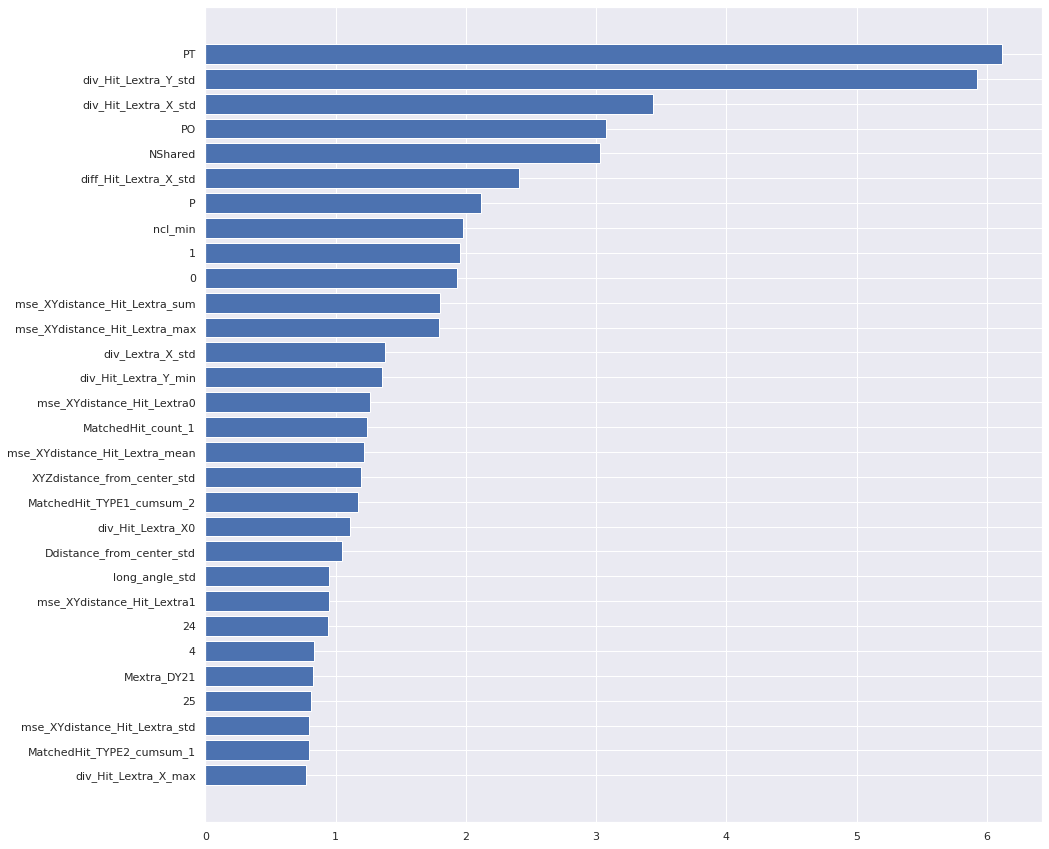

In [20]:
log_feature_importance(model)

In [59]:
predictions = model.predict_proba(df_test.loc[:, FEATURES])[:, 1]

submit_name = "sanity_check_test"
pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
    f"{DATA_PATH}{submit_name}.csv", index_label="id"
)
experiment.log_artifact(f"{DATA_PATH}{submit_name}.csv")

In [57]:
experiment.stop()